In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

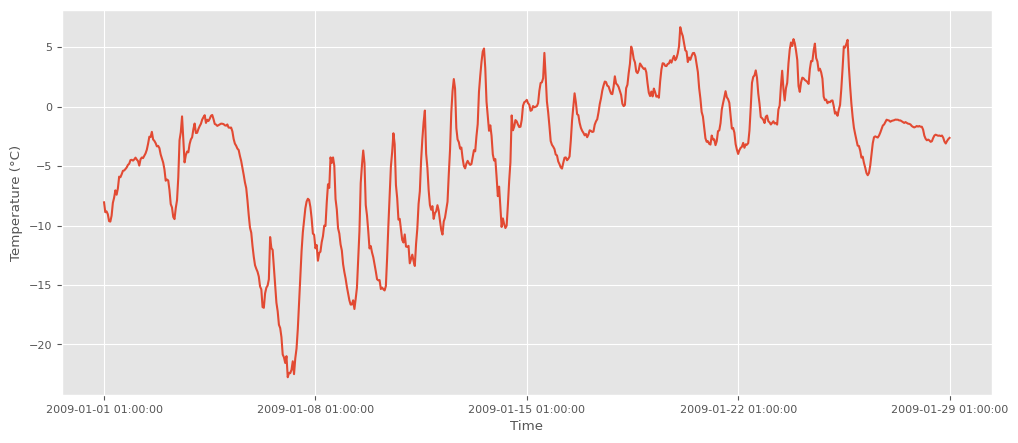

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

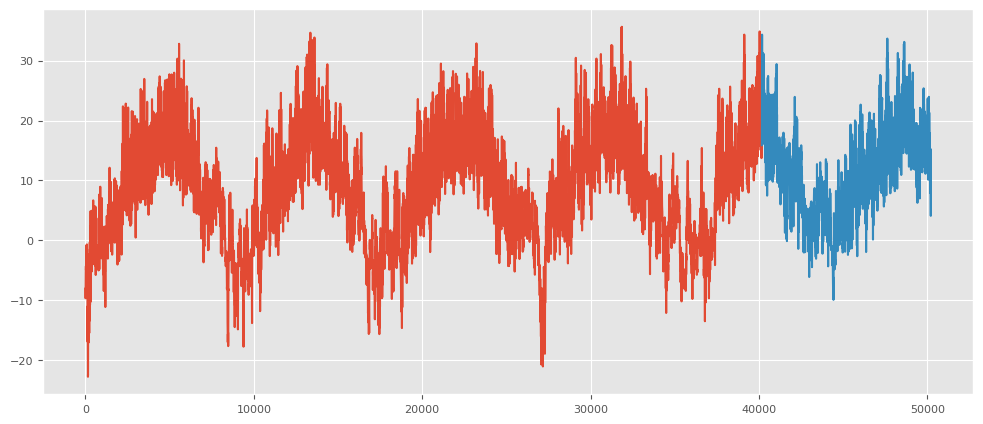

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

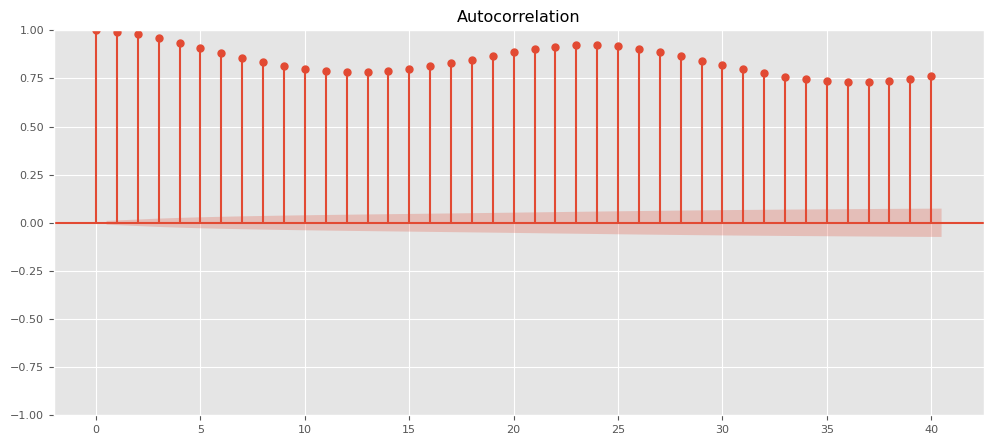

<Figure size 1200x500 with 0 Axes>

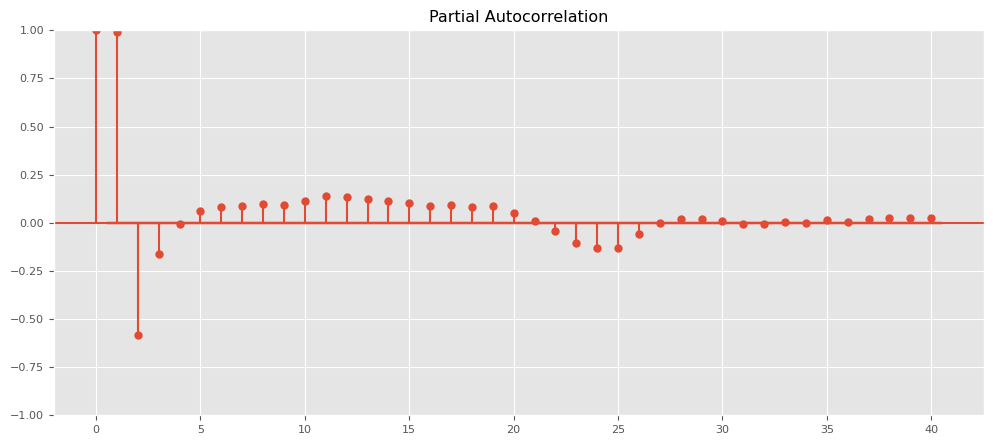

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EEMD

<Axes: xlabel='Time (samples)'>

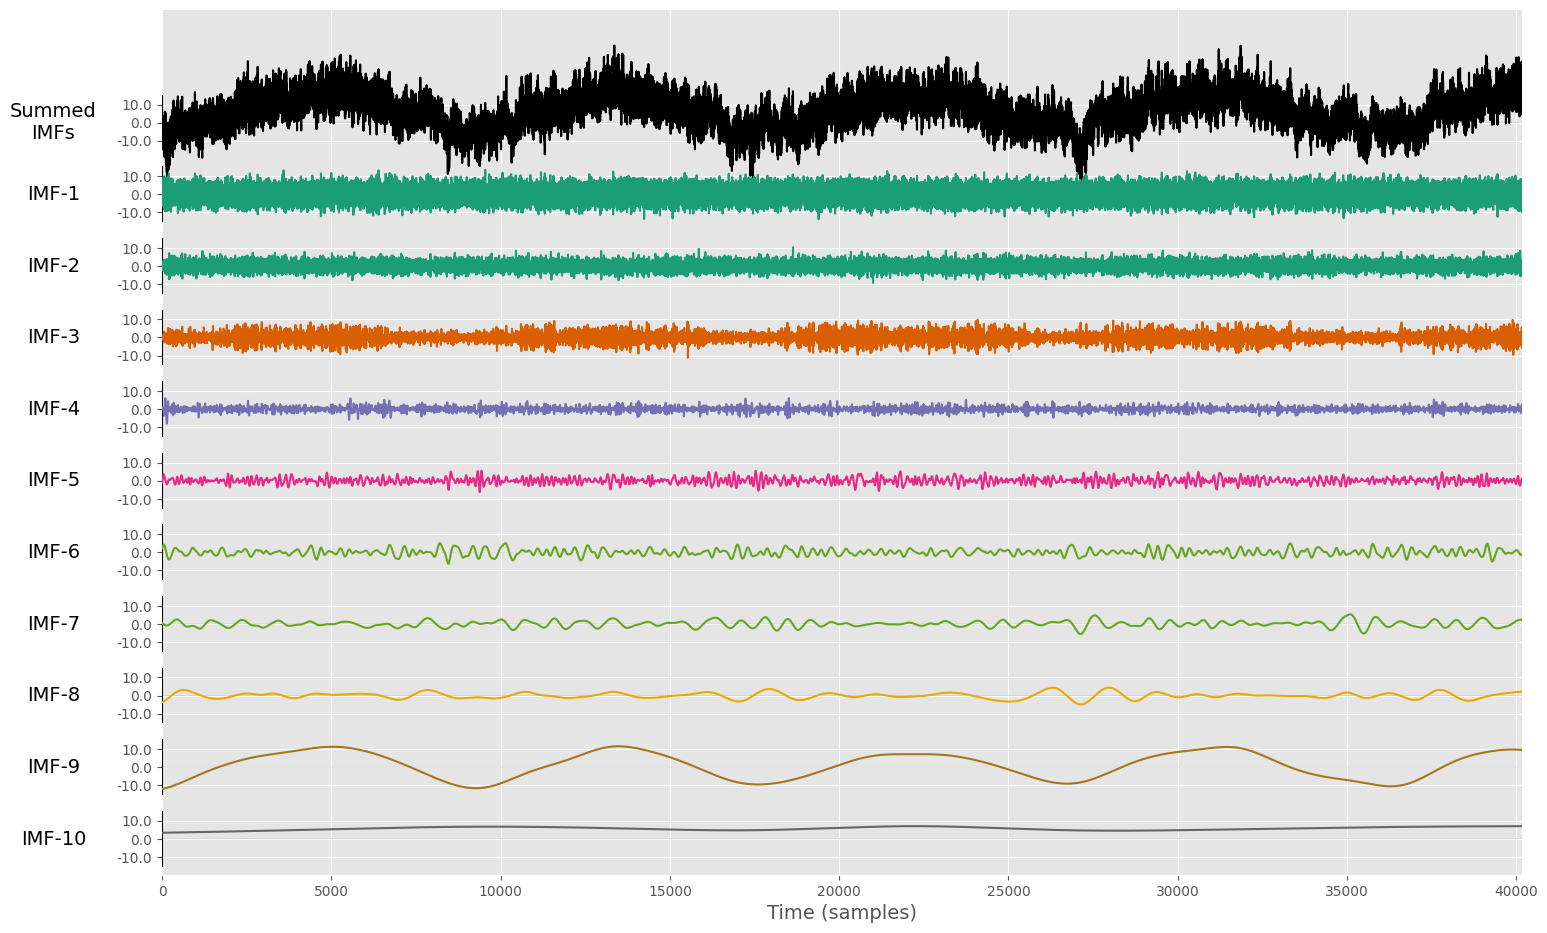

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,-5.498834,1.213018,0.166193,0.402090,-1.025450,2.408828,0.486203,-3.697952,-12.075487,3.328138
1,-1.881551,1.779369,0.003570,0.444089,-0.956981,2.462630,0.466258,-3.690253,-12.071651,3.328452
2,0.174110,2.054850,-0.016162,0.505269,-0.875503,2.516852,0.446430,-3.682483,-12.067805,3.328765
3,5.728240,1.860621,0.089037,0.578574,-0.781964,2.571424,0.426720,-3.674641,-12.063948,3.329078
4,0.489042,1.408746,0.281391,0.658308,-0.677321,2.626273,0.407129,-3.666729,-12.060079,3.329392
...,...,...,...,...,...,...,...,...,...,...
40174,-1.127178,-0.315930,-4.655412,2.595381,1.366107,-1.287929,2.279610,2.112679,9.533762,6.957627
40175,8.016738,0.969229,-5.366973,2.692993,1.374794,-1.273446,2.277127,2.113079,9.531965,6.957656
40176,1.766105,1.361635,-5.783633,2.750203,1.378567,-1.258423,2.274582,2.113472,9.530160,6.957686
40177,-10.132830,0.980381,-5.867335,2.764183,1.377387,-1.242864,2.271978,2.113858,9.528349,6.957715


In [12]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

In [13]:
imf1_eemd_SVR_fc.shape

(10045,)

In [14]:
# imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
# imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

# imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
# imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

In [15]:
# # train imf10 using ARIMA model
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(train, order=(2, 1, 0))
# model_fit = model.fit(imf_eemd_df['imf_eemd_10'])

# imf10_eemd_arima_fc = model_fit.forecast(steps = len(test))

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Preparar los datos
imf10_train = imf_eemd_df['imf_eemd_10'].values

# Definir y ajustar el modelo ARIMA
imf10_eemd_ARIMA = ARIMA(imf10_train, order=(2, 1, 0))
imf10_eemd_ARIMA_fit = imf10_eemd_ARIMA.fit()

# Predecir con el modelo ARIMA
imf10_test = df_test.values
imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(imf10_test))

# Si quieres predecir los valores de entrenamiento también
# imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.predict(start=0, end=len(imf10_train)-1)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


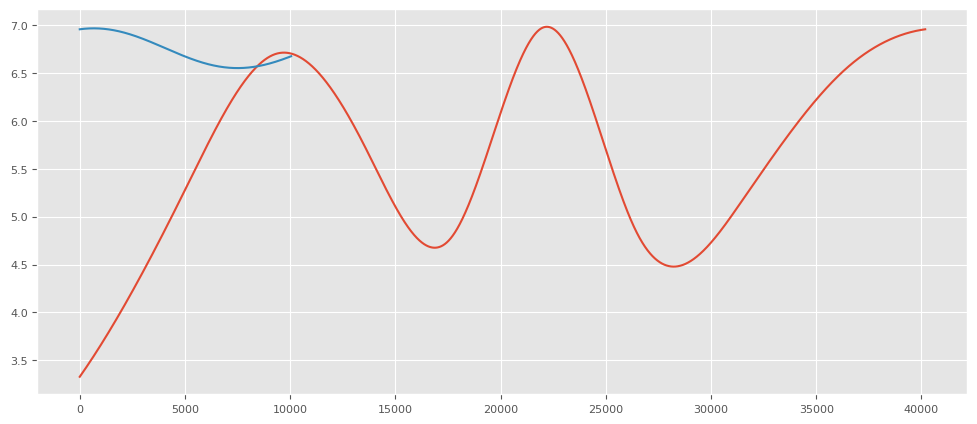

In [17]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_10'])
plt.plot(imf10_eemd_ARIMA_fc)
plt.show()

In [18]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_ARIMA_fc], axis = 0)

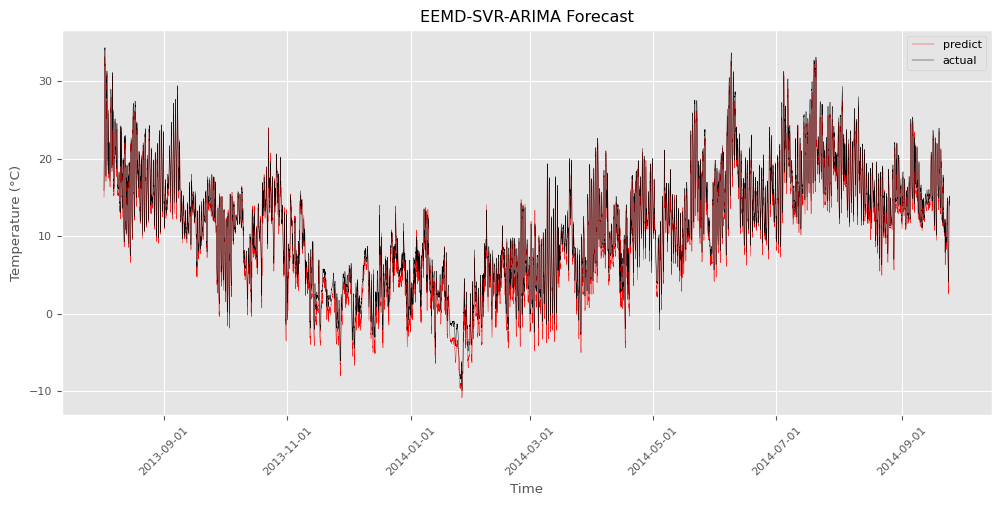

In [19]:
import matplotlib.dates as mdates
import pandas as pd

target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-SVR-ARIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [20]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 1.9426236080772443 
MAE = 1.1113512570204083 
MAPE = 1374685029260.062


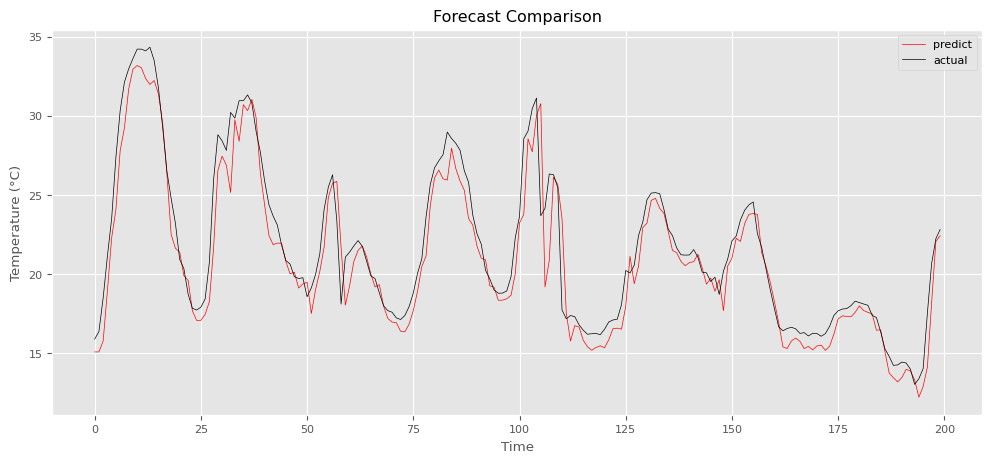

MSE = 1.9426236080772443 
MAE = 1.1113512570204083 
MAPE = 1374685029260.062


In [21]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [22]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))

In [23]:
imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))

In [24]:
imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_ARIMA_fc], axis = 0)

In [25]:
from scipy.optimize import minimize

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 1.126979
         Iterations: 38
         Function evaluations: 77
[1.01326535]


In [26]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 1.07637998839256 
MAE = 0.776094209838868 
MAPE = 466105346984.6933


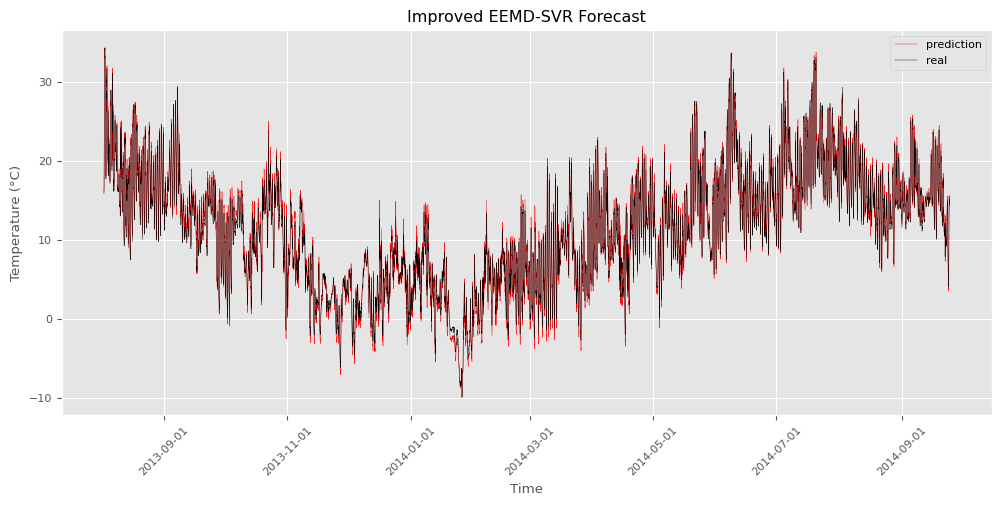

In [27]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

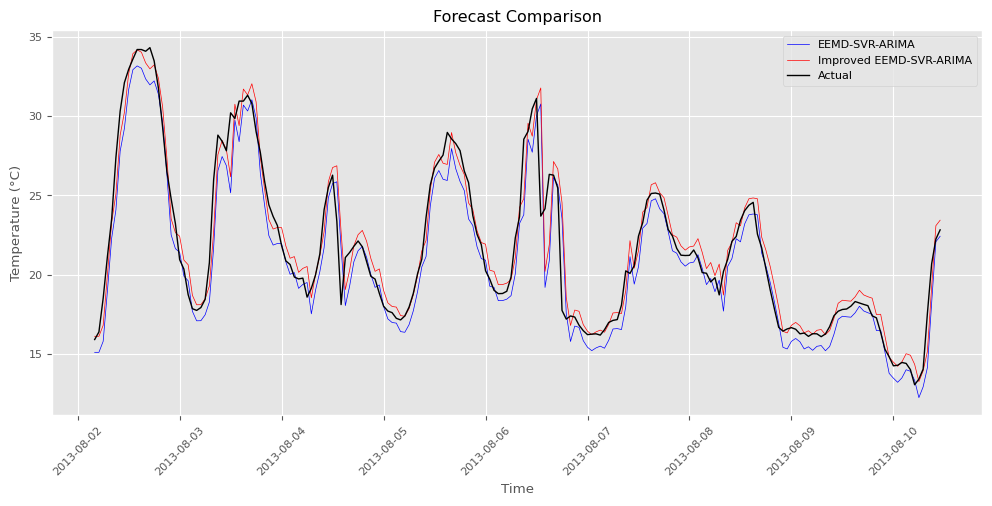

In [28]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-SVR-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-SVR-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()